In [11]:
import sys
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
from copy import deepcopy
import matplotlib as mpl
from pathlib import Path
from tqdm import tqdm
import shutil

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, 
    average_precision_score,
)

sys.path.append("../")
from classification.data.misc import class_name_to_index, n_classes
from classification.data.misc import (
    get_image_from_dcm, window_image, get_metadata_from_dcm)

class_names = list(class_name_to_index.keys())

class_name_to_index = deepcopy(class_name_to_index)
class_name_to_index["none"] = class_name_to_index["any"]
del class_name_to_index["any"]

In [2]:
filename_split = "../data/processed/split.pkl"
split_data = pkl.load(open(filename_split, "rb"))

split_name = "test"
data = split_data[f"{split_name}_data"]
labels = split_data[f"{split_name}_labels"]

id_to_index = {i2: i1 for i1, i2 in enumerate(data.sop_id.values)}

# filename_pred = f"../res/preds_4_{split_name}_last.pkl"
filename_pred = f"../res/preds_11_{split_name}_4.pkl"
# filename_pred = f"../res/preds_ext_{split_name}_0.pkl"
# filename_pred = f"../res/preds_13_{split_name}_1_seq.pkl"
filename_pred = f"../res/preds_14_{split_name}_seq_5.pkl"
pred_data = pkl.load(open(filename_pred, "rb"))

pred_ids = pred_data["ids"]
preds = pred_data["preds"]
pred_pat_ids = pred_data["patient_ids"]
preds_pat = pred_data["patient_preds"]

# preds[:, -1] = 1 - preds[:, :-1].sum(axis=1)
# preds[:, -1] = 1 - preds[:, :-1].max(axis=1)
# preds_pat[:, -1] = 1 - preds_pat[:, :-1].max(axis=1)

targets = labels[[id_to_index[i] for i in pred_ids]]

preds_label = np.argmax(preds, axis=1)
targets_label = np.argmax(targets, axis=1)

assert np.all(pred_ids == data.sop_id.values)

print(preds.shape, targets.shape, preds_label.shape, targets_label.shape)

preds_study = []
labels_study = []

s_ids_un = np.unique(data.study_id.values)
for s in s_ids_un:
    inds = np.where(data.study_id.values == s)[0]
    ls = labels[inds]
    ls_s = ls.max(axis=0)
    ls_s[-1] = ls_s[:-1].max()
    ps = preds[inds]
    ps_s = ps.max(axis=0)
    ps_s[-1] = 1 - ps[:, -1].min()
    
    cl = [class_names[i] for i, l in enumerate(ls_s) if l>0]
    
    # print(s, ls_s, ps_s, cl)
    
    preds_study.append(ps_s)
    labels_study.append(ls_s)
    
preds_study = np.array(preds_study, np.float32)
labels_study = np.array(labels_study, np.float32)
print(preds_study.shape, labels_study.shape)

(75525, 6) (75525, 6) (75525,) (75525,)
(2183, 6) (2183, 6)


In [3]:
print(np.sum(targets, axis=0))
print(np.mean(targets, axis=0))
print(np.sum(labels_study, axis=0))
print(np.mean(labels_study, axis=0))

[  351.  3543.  2590.  3541.  4797. 64656.]
[0.00464747 0.04691162 0.03429328 0.04688514 0.06351539 0.8560874 ]
[ 37. 531. 371. 405. 395. 904.]
[0.01694915 0.24324325 0.1699496  0.18552451 0.18094365 0.41410902]


In [4]:
thresholds = [0.1]*preds.shape[1]
# thresholds = [0.1, 0.1, 0.1, 0.1, 0.1, 0.9]
preds_bin = preds >= np.expand_dims(thresholds, 0)
preds_bin_any = (1-preds[:, -1]) >= thresholds[-1]

metric_dict = {
    "auc": roc_auc_score,
    "ap": average_precision_score,
}
metric_dict_bin = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score,
    "mcc": matthews_corrcoef, 
}
metric_dict.update(metric_dict_bin)
scores = {}


for metric_name, metric_func in metric_dict.items():
    score_list = []
    if metric_name in metric_dict_bin:
        p = preds_bin
    else:
        p = preds
    for class_name, class_index in class_name_to_index.items():
        s = metric_func(targets[:, class_index], p[:, class_index])
        scores[f"{metric_name} {class_name}"] = s
        if class_name == "none":
            if metric_name in metric_dict_bin:
                s = metric_func(1-targets[:, class_index], preds_bin_any)
            else:
                s = metric_func(1-targets[:, class_index], 1-p[:, class_index])
            scores[f"{metric_name} any"] = s
        score_list.append(s)
    if metric_name in metric_dict_bin:
        scores[f"{metric_name} <multilabel>"] = np.mean(score_list)
        add_args = {}
        if metric_name in ["precision", "recall", "f1"]:
            add_args["average"] = "macro"
        scores[f"{metric_name} <multiclass>"] = metric_func(
            targets_label, preds_label, **add_args)
    else:
        scores[f"{metric_name} <mean>"] = np.mean(score_list)
        scores[f"{metric_name} <multiclass>"] = metric_func(targets, preds, average="macro")
    
        
thresholds_agg = np.copy(thresholds)
preds_study_bin = preds_study >= np.expand_dims(thresholds_agg, 0)
scores_agg = {}
for metric_name, metric_func in metric_dict.items():
    score_list = []
    if metric_name in metric_dict_bin:
        p = preds_study_bin
    else:
        p = preds_study
    for class_index, class_name in enumerate(class_names):
        s = metric_func(labels_study[:, class_index], p[:, class_index])
        scores_agg[f"{metric_name} {class_name}"] = s
        score_list.append(s)
    scores_agg[f"{metric_name} <mean>"] = np.mean(score_list)

In [5]:
for k, v in scores.items():
    print(f"{k:30s} {v:.3f}")

auc epidural                   0.960
auc intraparenchymal           0.992
auc intraventricular           0.995
auc subarachnoid               0.979
auc subdural                   0.977
auc none                       0.987
auc any                        0.987
auc <mean>                     0.982
auc <multiclass>               0.982
ap epidural                    0.138
ap intraparenchymal            0.896
ap intraventricular            0.903
ap subarachnoid                0.768
ap subdural                    0.814
ap none                        0.998
ap any                         0.933
ap <mean>                      0.742
ap <multiclass>                0.753
accuracy epidural              0.989
accuracy intraparenchymal      0.978
accuracy intraventricular      0.980
accuracy subarachnoid          0.947
accuracy subdural              0.948
accuracy none                  0.937
accuracy any                   0.938
accuracy <multilabel>          0.963
accuracy <multiclass>          0.930
p

In [6]:
for k, v in scores_agg.items():
    print(f"{k:30s} {v:.3f}")

auc epidural                   0.921
auc intraparenchymal           0.981
auc intraventricular           0.986
auc subarachnoid               0.958
auc subdural                   0.959
auc any                        0.986
auc <mean>                     0.965
ap epidural                    0.186
ap intraparenchymal            0.954
ap intraventricular            0.950
ap subarachnoid                0.868
ap subdural                    0.866
ap any                         0.984
ap <mean>                      0.801
accuracy epidural              0.960
accuracy intraparenchymal      0.938
accuracy intraventricular      0.936
accuracy subarachnoid          0.880
accuracy subdural              0.897
accuracy any                   0.932
accuracy <mean>                0.924
precision epidural             0.177
precision intraparenchymal     0.836
precision intraventricular     0.745
precision subarachnoid         0.628
precision subdural             0.660
precision any                  0.880
p

In [104]:
# name_in = "preds_2dv10_test_0"
# name_out = "2dv10_0"

# v11
# name_in = "preds_7_test_subm_0"
# name_out = "2dv11_0"

# v12
# name_in = "preds_8_subm_0"
# name_out = "2dv12_0"

# v14
# name_in = "preds_10_subm_0"
# name_out = "2dv14_0"

# v15
# name_in = "preds_11_subm_3"
# name_out = "2dv15_3"

# # v16
# name_in = "preds_12_subm_0"
# name_out = "2dv16_0"

# v15 + seq
# name_in = "preds_13_subm_2_seq"
name_in = "preds_14_subm_seq_5"
name_out = "2dv15_seq_3"

pred_data_test = pkl.load(open(f"../res/{name_in}.pkl", "rb"))
sample_data = pd.read_csv("../data/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv")

pred_ids = pred_data_test["ids"]
preds = pred_data_test["preds"]

p_to_ind = {p: i for i, p in enumerate(pred_ids)}

print(sample_data.head())

preds_out = np.zeros_like(sample_data.Label.values)
for index, id in enumerate(sample_data.ID.values):
    sop_id = id.split("_")[1]
    class_name = id.split("_")[2]

    if class_name == "any":
        class_index = class_name_to_index["none"]
        p = preds[p_to_ind[sop_id], class_index]
        p = 1-p
    else:
        class_index = class_name_to_index[class_name]
        p = preds[p_to_ind[sop_id], class_index]

    preds_out[index] = p

print(preds.shape, preds.shape[0]*preds.shape[1], preds.min(), preds.max(), preds.mean())
print(preds_out.shape, preds_out.min(), preds_out.max(), preds_out.mean())

sample_data.Label.values[:] = preds_out
print(sample_data.head())

sample_data.to_csv(f"../res/submissions/{name_out}.csv", index=False)

                              ID  Label
0          ID_0fbf6a978_epidural    0.5
1  ID_0fbf6a978_intraparenchymal    0.5
2  ID_0fbf6a978_intraventricular    0.5
3      ID_0fbf6a978_subarachnoid    0.5
4          ID_0fbf6a978_subdural    0.5
(121232, 6) 727392 6.2910505e-27 1.0 0.17425777
(727392,) 0.0 0.9999927858875708 0.0526128335444171
                              ID     Label
0          ID_0fbf6a978_epidural  0.002380
1  ID_0fbf6a978_intraparenchymal  0.014482
2  ID_0fbf6a978_intraventricular  0.031559
3      ID_0fbf6a978_subarachnoid  0.196971
4          ID_0fbf6a978_subdural  0.078441


In [9]:
data_train = pd.read_csv("../data/processed/train_dcm_data.csv")
print(data_train.head())

study_id_inds = {}
study_ids_un = np.unique(data_train.study_id.values)
for s in tqdm(study_ids_un):
    inds = np.where(data_train.study_id.values == s)[0]
    study_id_inds[s] = inds

lens = [len(v) for v in study_id_inds.values()]
print(min(lens), max(lens), np.mean(lens))

   Unnamed: 0     sop_id    study_id   series_id patient_id  slope  intercept  \
0           0  12cadc6af  6dec708c74  1b17a4a944   2eb3925f    1.0    -1024.0   
1           1  38fd7baa0  0a9ac70962  3f92acee54   e18d3063    1.0    -1024.0   
2           2  6c5d82413  45e4c06199  5467fe8129   dbb88395    1.0    -1024.0   
3           3  aec8e68b3  0d739f7065  e01d9cd8c9   dbfa26fc    1.0    -1024.0   
4           4  4d9209c7c  f361229319  04b809de14   ce982e0b    1.0    -1024.0   

   window_center  window_width  position_x  position_y  position_z  \
0           30.0          80.0      -125.0 -145.337000   71.652000   
1           30.0          80.0      -125.0 -140.052000  226.174000   
2           36.0          80.0      -115.0  -22.000000 -199.400009   
3           30.0          80.0      -125.0 -109.982063   98.205338   
4           36.0          80.0      -125.0   -8.000000  280.300049   

   orientation_0  orientation_1  orientation_2  orientation_3  orientation_4  \
0           

 62%|██████▏   | 13470/21744 [02:10<01:20, 103.35it/s]


KeyboardInterrupt: 

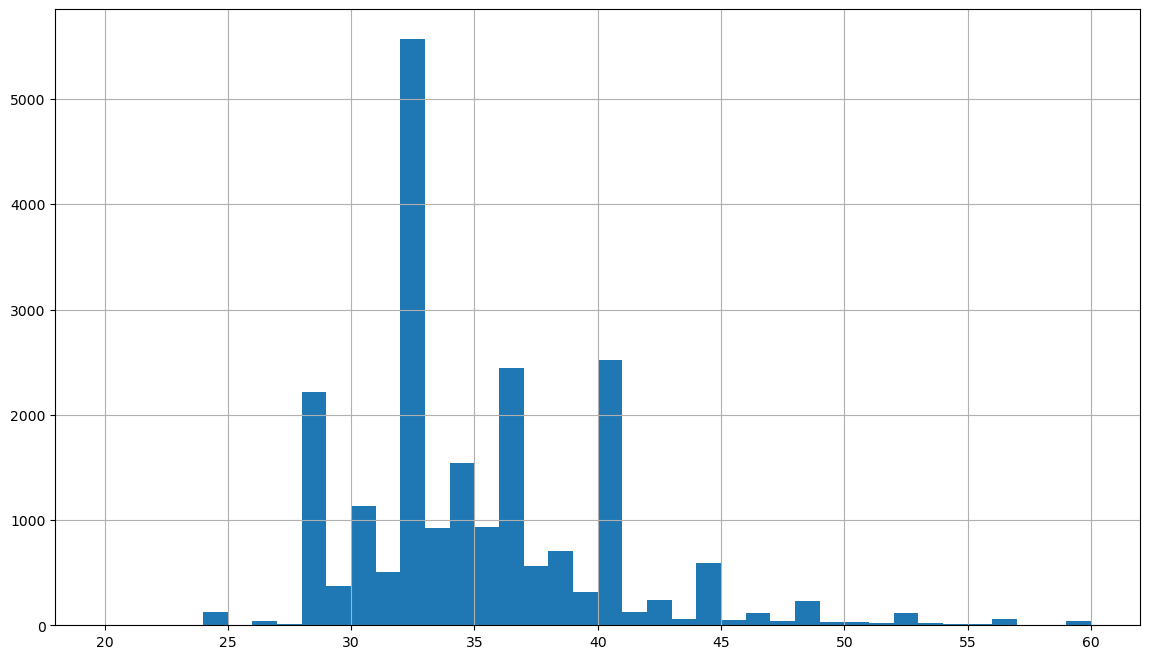

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

bins = np.arange(min(lens), max(lens)+1, 1)

ax.hist(lens, bins=bins)

ax.grid()

plt.show()

In [8]:
inds_test = open("../data/processed/split_test.txt").read().strip().split("\n")
print(inds_test[:10])

['19424a7b8', '9adaf4665', '8e1e84a61', 'f7d41c76b', '12d7421d2', '0e5fbf085', '14cd16966', 'e1444b423', '820fc8eed', '76090c387']


In [7]:
def crossentropy(targets: np.ndarray, preds: np.ndarray) -> np.ndarray:
    targets = targets.astype(np.float32)
    return - (targets * np.log(preds + 1e-9) + (1 - targets) * np.log(1 - preds + 1e-9))

preds_study = []
labels_study = []
ce_study = []
ce_slice_study = []
study_nums = []

preds_initial = pred_data.get("preds_initial", preds)

s_ids_un = np.unique(data.study_id.values)
for s in s_ids_un:
    inds = np.where(data.study_id.values == s)[0]
    ls = np.copy(labels[inds])
    ls[:, -1] = 1 - ls[:, -1]
    ls_s = ls.max(axis=0)
    ps = np.copy(preds[inds])
    ps[:, -1] = 1. - ps[:, -1]
    ps_s = ps.max(axis=0)
    
    cl = [class_names[i] for i, l in enumerate(ls_s) if l>0]
    
    ls = (ls == 1).astype(np.uint8)
    ls_s = (ls_s == 1).astype(np.uint8)
    
    ce = crossentropy(ls, ps).mean(axis=0)
    ce_s = crossentropy(ls_s, ps_s)
    
    print(s, len(inds), ls_s, " ".join(f"{v:.3f}" for v in ps_s))
    
    preds_study.append(ps_s)
    labels_study.append(ls_s)
    ce_study.append(ce)
    ce_slice_study.append(ce_s)
    study_nums.append(len(inds))
    
preds_study = np.array(preds_study)
labels_study = np.array(labels_study)
ce_study = np.array(ce_study)
ce_slice_study = np.array(ce_study)
study_nums = np.array(study_nums)

data_studies = {
    "study_id": s_ids_un,
    "nums": study_nums,
}
for i, c in enumerate(class_names):
    data_studies[f"label_{i}"] = labels_study[:, i]
    data_studies[f"pred_{i}"] = preds_study[:, i]
    data_studies[f"ce_loss_{i}"] = ce_study[:, i]
    data_studies[f"ce_loss_slices_{i}"] = ce_slice_study[:, i]
data_studies["ce_loss"] = ce_study.mean(axis=1)
data_studies["ce_loss_slices"] = ce_slice_study.mean(axis=1)

data_studies = pd.DataFrame(data_studies)
# print(data_studies.shape)
# print(data_studies.head())

0006600dd8 42 [0 0 0 0 0 0] 0.000 0.001 0.000 0.001 0.007 0.011
00200ca5f0 32 [0 1 0 0 0 1] 0.002 0.356 0.033 0.015 0.022 0.411
0043db2b67 36 [0 1 1 0 0 1] 0.000 0.960 0.987 0.070 0.020 0.995
0044bf364c 37 [0 0 0 1 0 1] 0.004 0.638 0.006 0.467 0.293 0.898
005db3cff9 34 [0 0 0 0 0 0] 0.000 0.000 0.000 0.000 0.000 0.001
00631898cf 32 [0 0 0 1 0 1] 0.028 0.060 0.015 0.921 0.034 0.967
0070ac8ea8 40 [0 0 0 0 0 0] 0.000 0.000 0.000 0.000 0.001 0.001
0088dfe60f 33 [0 1 1 1 0 1] 0.004 0.798 0.262 0.986 0.062 0.997
009eb6b150 38 [0 0 0 0 0 0] 0.000 0.001 0.000 0.000 0.003 0.004
00b32fa77f 35 [0 0 0 0 0 0] 0.000 0.002 0.000 0.002 0.005 0.011
00d9f9aa3a 33 [0 0 0 0 0 0] 0.000 0.000 0.000 0.000 0.001 0.002
00dbeb391b 40 [0 0 0 0 0 0] 0.000 0.000 0.000 0.000 0.000 0.000
00f3e76020 38 [0 0 0 0 1 1] 0.014 0.002 0.003 0.004 0.972 0.969
010b7f38e0 34 [1 0 0 0 0 1] 0.027 0.004 0.002 0.005 0.982 0.985
012244ec78 29 [0 0 0 0 0 0] 0.000 0.002 0.000 0.002 0.005 0.011
0131753d39 32 [0 0 0 0 0 0] 0.000 0.000 

In [13]:
n = 5

threshold_l = 0.1
threshold_h = 0.8

folder_from = Path("../data/rsna-intracranial-hemorrhage-detection/stage_2_train")

folder_samples = Path("../data/selected_studies")
if folder_samples.exists():
    shutil.rmtree(folder_samples)
folder_samples.mkdir()


for class_index, class_name in enumerate(class_names):
    ls = data_studies[f"label_{class_index}"].values
    ps = data_studies[f"pred_{class_index}"].values
    ce = data_studies[f"ce_loss_{class_index}"].values
    
    inds_class = np.where(ls == 1)[0]
    inds_sort = np.argsort(ce[inds_class])
    inds_best = inds_sort[:n]
    inds_worst = inds_sort[-n:][::-1]
    inds_best = inds_class[inds_best]
    inds_worst = inds_class[inds_worst]
    
    inds_fn = np.where((ls == 1) & (ps < threshold_l))[0]
    inds_fn = inds_fn[np.argsort(ce[inds_fn])[::-1]]
    inds_fn = inds_fn[:n]

    inds_fp = np.where((ls == 0) & (ps > threshold_h))[0]
    inds_fp = inds_fp[np.argsort(ce[inds_fp])[::-1]]
    inds_fp = inds_fp[:n]
    
    folder_class = folder_samples.joinpath(class_name)
    folder_class.mkdir()
    for b, inds in zip(["best", "worst", "fn", "fp"], [inds_best, inds_worst, inds_fn, inds_fp]):
        folder_type = folder_class.joinpath(b)
        folder_type.mkdir()
        for i, index in enumerate(inds):
            study_id = data_studies.study_id[index]
            print(class_index, class_name, b, i, index, study_id, ls[index], ps[index], ce[index])
            ii = np.where(data.study_id.values == study_id)[0]
            folder_study = folder_type.joinpath(study_id)
            folder_study.mkdir()
            for sop_id in data.sop_id.values[ii]:
                shutil.copy2(folder_from.joinpath(f"ID_{sop_id}.dcm"), folder_study)
            

0 epidural best 0 1306 97c3dd9651 1 0.009184199 0.16181003
0 epidural best 1 1482 acc1453e1d 1 0.99974614 0.165426
0 epidural best 2 860 64de33f30f 1 0.8335552 0.21350132
0 epidural best 3 757 59147d83c7 1 0.81675506 0.23201604
0 epidural best 4 1167 8906789ef7 1 0.13712116 0.2701257
0 epidural worst 0 1467 ab2b3b75a8 1 0.024307495 3.5271573
0 epidural worst 1 145 0ffdf20f08 1 0.017906222 3.215151
0 epidural worst 2 1553 b4fcf2f799 1 0.0012866883 2.5074358
0 epidural worst 3 13 010b7f38e0 1 0.026703004 1.9270047
0 epidural worst 4 1851 d8d43db68d 1 0.024536455 1.829604
0 epidural fn 0 1467 ab2b3b75a8 1 0.024307495 3.5271573
0 epidural fn 1 145 0ffdf20f08 1 0.017906222 3.215151
0 epidural fn 2 1553 b4fcf2f799 1 0.0012866883 2.5074358
0 epidural fn 3 13 010b7f38e0 1 0.026703004 1.9270047
0 epidural fn 4 1851 d8d43db68d 1 0.024536455 1.829604
0 epidural fp 0 985 750dd2e742 0 0.97359324 1.3235953
0 epidural fp 1 178 13e28cb7ef 0 0.93373966 0.6651538
0 epidural fp 2 1620 bd058df0b9 0 0.9474

study_id d437cc8776
n= 32
labels [1 1 1 1 1 1]
preds 0.856 0.862 0.192 0.638 0.460 0.976
classes ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
crossentropy 0.155 0.148 1.651 0.449 0.777 0.024
crossentropy mean 0.693 0.181 0.080 0.202 0.487 0.148


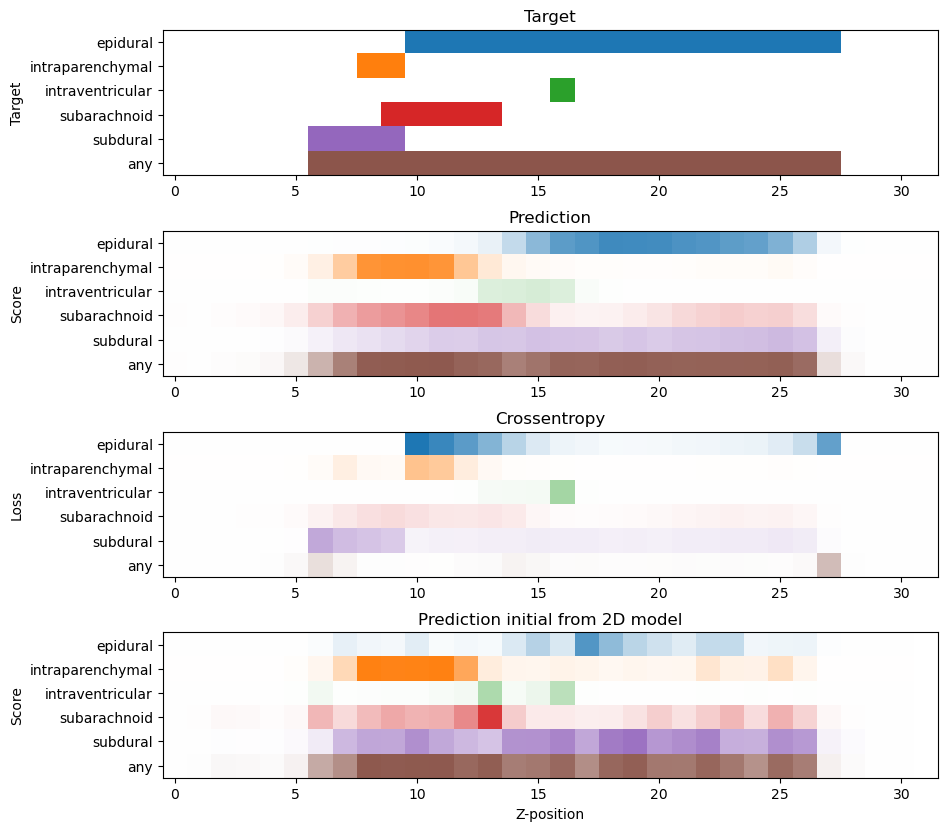

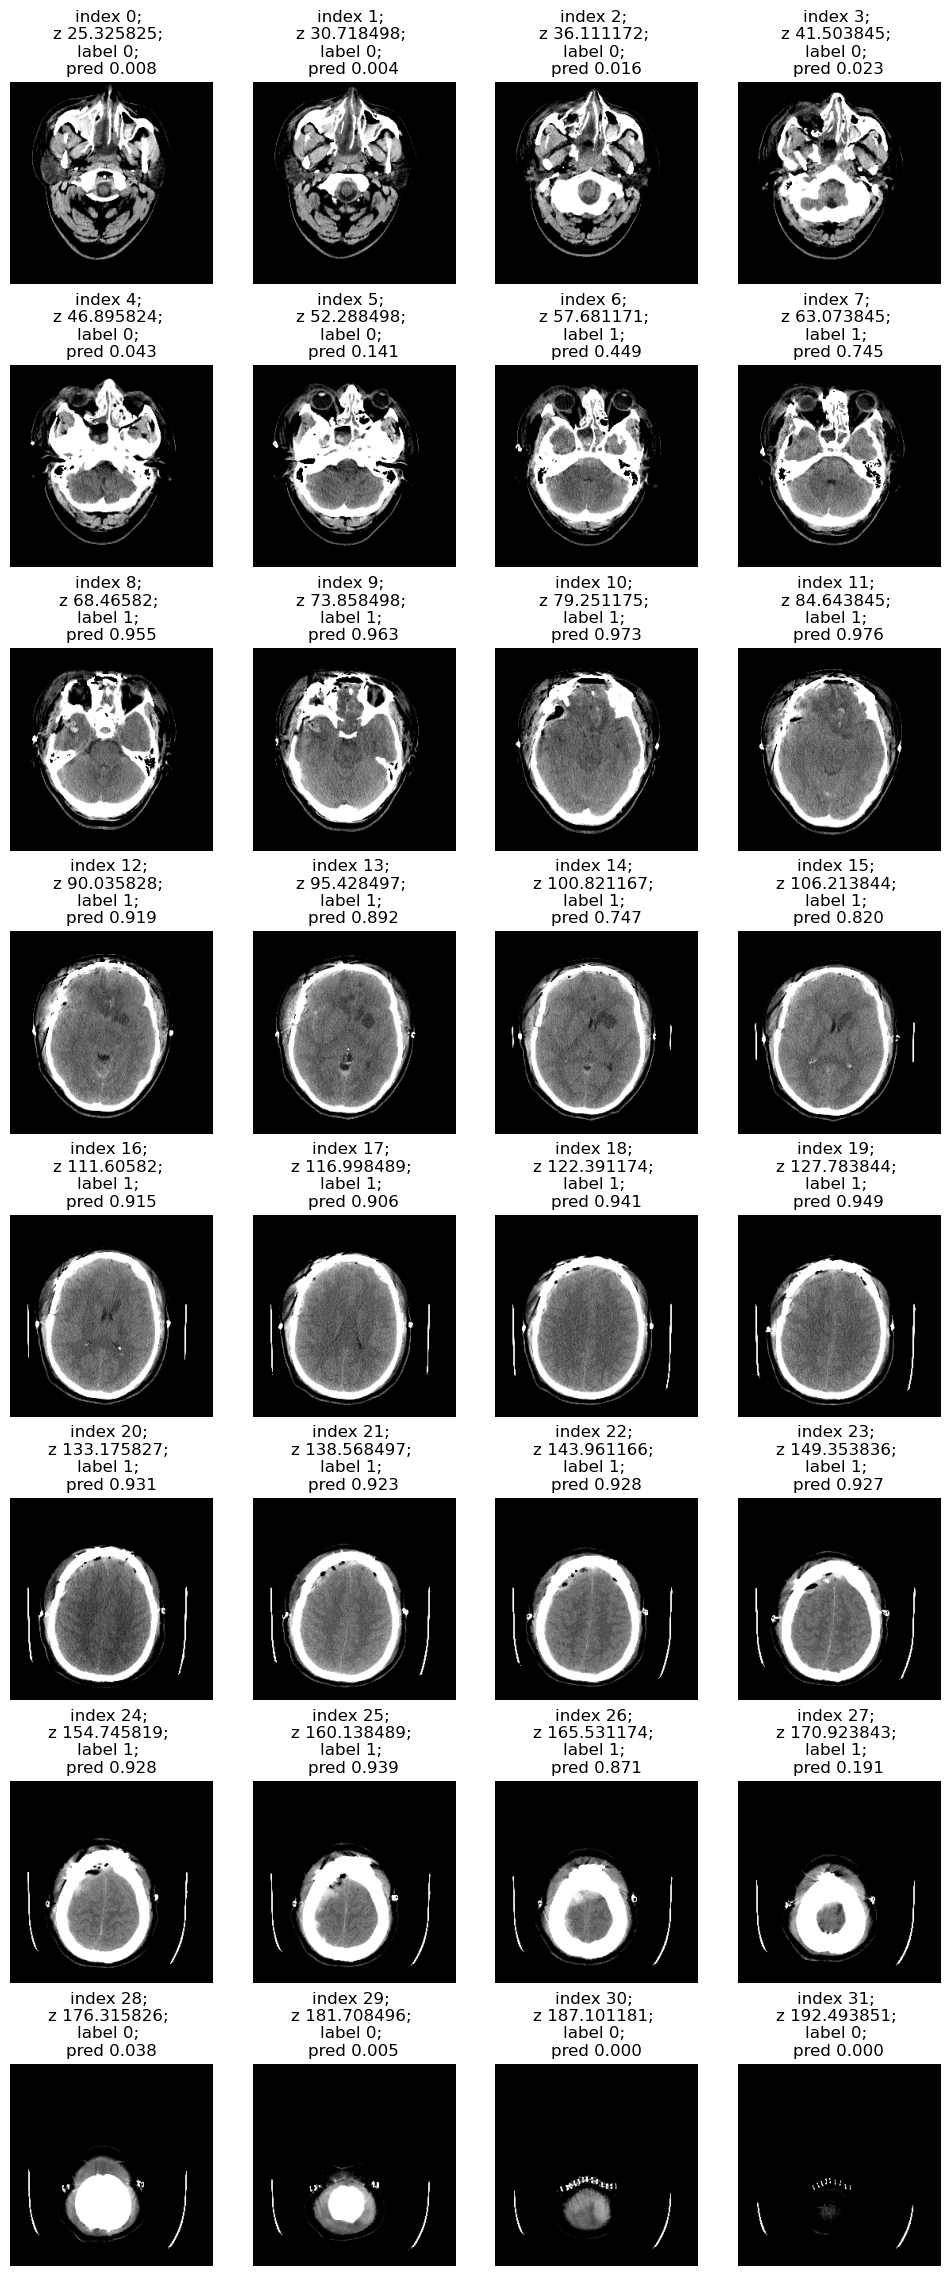

In [10]:
folder_dcm = "../data/rsna-intracranial-hemorrhage-detection/stage_2_train"
folder_dcm = Path(folder_dcm)

def load_study_images(inds: np.ndarray) -> np.ndarray:
    sop_ids = data.sop_id.values[inds]
    images = []
    for sop_id in sop_ids:
        filename = folder_dcm.joinpath(f"ID_{sop_id}.dcm")
        img = get_image_from_dcm(filename)
        dcm_data = get_metadata_from_dcm(filename)
        img = window_image(img, 
            intercept=dcm_data["intercept"], slope=dcm_data["slope"])
        # print(sop_id, 
        #     dcm_data["intercept"], dcm_data["slope"],  
        #     img.shape, img.min(), img.max(), len(np.unique(img)))
        images.append(img)
    return np.array(images)

cmap = mpl.colormaps["tab10"]
def get_score_image(scores: np.ndarray) -> np.ndarray:
    image = np.zeros((scores.shape[1], scores.shape[0], 3), np.float32)
    for i in range(scores.shape[1]):
        color = np.expand_dims(np.array(cmap.colors[i], np.float32), 0)
        image[i] = 1 - (1 - color) * np.expand_dims(scores[:, i], 1)
    return image

def show_single_scores(
        ax, 
        scores: np.ndarray, 
        z: np.ndarray,
        lim_is_1 : bool = True,
        ):
    for class_index, class_name in enumerate(class_names):
        color = cmap.colors[class_index]
        pos = z + 0.1*class_index
        ax.plot(pos, scores[:, class_index], alpha=0.5, linewidth=1, color=color)
        ax.fill_between(pos, scores[:, class_index], 0, alpha=0.3, color=color, label=class_name)
    if lim_is_1:
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(0)
    ax.set_xlim(z.min(), z.max())
    ax.spines[['right', 'top']].set_visible(False)        
    ax.grid()
    ax.legend()
    return


def show_single_scores_image(ax, scores: np.ndarray, lim_is_1 : bool = True):
    if not lim_is_1:
        scores = scores / scores.max()
    image = get_score_image(scores)
    ax.imshow(image)
    ax.set_yticks(np.arange(scores.shape[1]))
    ax.set_yticklabels(class_names)
    return 


def show_pred_scores(study_id: str):
    inds = np.where(data.study_id.values == study_id)[0]
    
    z = data.position_z.values[inds]
    inds = inds[np.argsort(z)]
    z = data.position_z.values[inds]
    
    ls = np.copy(labels[inds])
    ls[:, -1] = 1 - ls[:, -1]
    ls_s = ls.max(axis=0)
    ps = np.copy(preds[inds])
    ps[:, -1] = 1. - ps[:, -1]
    ps_s = ps.max(axis=0)
    
    ps_init = np.copy(preds_initial[inds])
    ps_init[:, -1] = 1. - ps_init[:, -1]
    
    cl = [class_names[i] for i, l in enumerate(ls_s) if l>0]
    
    ls = (ls == 1).astype(np.uint8)
    ls_s = (ls_s == 1).astype(np.uint8)
    
    ce = crossentropy(ls, ps)
    ce_s = crossentropy(ls_s, ps_s)
    
    print("study_id", study_id)
    print("n=", len(inds))
    print("labels", ls_s)
    print("preds", " ".join(f"{v:.3f}" for v in ps_s))
    print("classes", cl)
    print("crossentropy", " ".join(f"{v:.3f}" for v in ce_s))
    print("crossentropy mean", " ".join(f"{v:.3f}" for v in ce.mean(axis=0)))
    
    fig, ax = plt.subplots(4, figsize=(10, 10))
    
    # for class_index, class_name in enumerate(class_names):
    #     color = cmap.colors[class_index]
    #     pos = z + 0.1*class_index
    #     if any(ls[:, class_index] > 0):
    #         ax[0].plot(pos, ls[:, class_index], alpha=0.5, linewidth=1, color=color)
    #         ax[0].fill_between(pos, ls[:, class_index], 0, color=color, alpha=0.3, label=class_name)
    #     ax[1].plot(pos, ps[:, class_index], alpha=0.5, linewidth=1, color=color)
    #     ax[1].fill_between(pos, ps[:, class_index], 0, color=color, alpha=0.3, label=class_name)
    #     ax[2].plot(pos, ce[:, class_index], alpha=0.5, linewidth=1, color=color)
    #     ax[2].fill_between(pos, ce[:, class_index], 0, color=color, alpha=0.3, label=class_name)
    #     ax[3].plot(pos, ps_init[:, class_index], alpha=0.5, linewidth=1, color=color)
    #     ax[3].fill_between(pos, ps_init[:, class_index], 0, color=color, alpha=0.3, label=class_name)
        
    
    # ax[0].set_ylim(0, 1)
    # ax[1].set_ylim(0, 1)
    # ax[2].set_ylim(0)
    # ax[3].set_ylim(0, 1)
    
    # for i in range(4):
    #     ax[i].set_xlim(z.min(), z.max())
    #     ax[i].spines[['right', 'top']].set_visible(False)        
    #     ax[i].grid()
    #     ax[i].legend()
    # ax[2].set_xlabel("Z-position")
    
    # show_single_scores(ax[0], scores=ls, z=z, lim_is_1=True)
    # show_single_scores(ax[1], scores=ps, z=z, lim_is_1=True)
    # show_single_scores(ax[2], scores=ce, z=z, lim_is_1=False)
    # show_single_scores(ax[3], scores=ps_init, z=z, lim_is_1=True)
    
    show_single_scores_image(ax[0], scores=ls, lim_is_1=True)
    show_single_scores_image(ax[1], scores=ps, lim_is_1=True)
    show_single_scores_image(ax[2], scores=ce, lim_is_1=False)
    show_single_scores_image(ax[3], scores=ps_init, lim_is_1=True)
    
    ax[3].set_xlabel("Z-position")
    
    ax[0].set_ylabel("Target")
    ax[1].set_ylabel("Score")
    ax[2].set_ylabel("Loss")
    ax[3].set_ylabel("Score")
        
    ax[0].title.set_text("Target")
    ax[1].title.set_text("Prediction")
    ax[2].title.set_text("Crossentropy")
    ax[3].title.set_text("Prediction initial from 2D model")
    
    plt.show()
    
    
    images = load_study_images(inds)
    
    n_cols = 4
    n_rows = int(np.ceil(len(inds) / n_cols))
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3.6*n_rows))
    
    for index in range(len(images)):
        i = index // n_cols
        j = index % n_cols
        ax[i, j].imshow(images[index], cmap='gray', vmin=0, vmax=1)
        ax[i, j].axis("off")
        ax[i, j].title.set_text(f"index {index}; \nz {z[index]}; "
            f"\nlabel {ls[index, class_index]}; \npred {ps[index, class_index]:.3f}"
            # f"\nlabel {' '.join(f'{v:d}' for v in ls[index])}; "
            # f"\npred {' '.join(f'{v:.2f}' for v in ps[index])}"
        )
        
    plt.show()
    
    return

# show_pred_scores("18b0309fe7")
# show_pred_scores("06898fef28")
# show_pred_scores("23c8bcf21d")
# show_pred_scores("e43d3c1006")
# show_pred_scores("6aa3f1d217")
# show_pred_scores("f98c217557")
# show_pred_scores("a84297c68a")
# show_pred_scores("56612347b5")
show_pred_scores("d437cc8776")

In [96]:
data.describe()

,Unnamed: 0,slope,intercept,window_center,window_width,position_x,position_y,position_z,orientation_0,orientation_1,orientation_2,orientation_3,orientation_4,orientation_5,pixel_spacing_x,pixel_spacing_y
count,75399.000000,75399.0,75399.000000,75399.000000,75399.000000,75399.000000,75399.000000,75399.000000,75399.0,75399.0,75399.0,75399.0,75399.000000,75399.000000,75399.000000,75399.000000
mean,375763.563761,1.0,-1015.903314,35.297418,92.655858,-122.723214,-63.624403,160.277665,1.0,0.0,0.0,0.0,0.970761,-0.168357,0.479304,0.479304
std,217807.248885,0.0,89.630039,14.163094,81.548012,9.003334,65.220282,233.023326,0.0,0.0,0.0,0.0,0.033395,0.167823,0.026608,0.026608
min,1.000000,1.0,-1024.000000,30.000000,68.000000,-184.000000,-202.040466,-470.734711,1.0,0.0,0.0,0.0,0.866025,-0.500000,0.325521,0.325521
25%,186567.000000,1.0,-1024.000000,30.000000,80.000000,-125.000000,-120.741000,67.343000,1.0,0.0,0.0,0.0,0.939693,-0.342020,0.488281,0.488281
50%,375878.000000,1.0,-1024.000000,36.000000,80.000000,-125.000000,-99.797981,123.456741,1.0,0.0,0.0,0.0,0.984808,-0.165048,0.488281,0.488281
75%,564797.000000,1.0,-1024.000000,36.000000,80.000000,-124.000000,-1.000000,185.169063,1.0,0.0,0.0,0.0,1.000000,0.000000,0.488281,0.488281
max,752802.000000,1.0,1.000000,500.000000,3000.000000,-55.000000,91.645695,1739.679070,1.0,0.0,0.0,0.0,1.000000,0.317305,0.679688,0.679688


In [99]:
data_all = pd.read_csv("../data/processed/train_dcm_data.csv")

inter_un, inter_counts = np.unique(data_all.intercept.values, return_counts=True)
inds = np.argsort(inter_counts)[::-1]
for n, c in zip(inter_un, inter_counts):
    print(n, c)

-1024.0 740736
-1000.0 6681
0.0 5336
1.0 50
